## Part 2: Exploratory Data Analysis (EDA) 

In [13]:
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython import display
display.set_matplotlib_formats("svg")

# Formatting 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.font_manager as font_manager
font_dir = ["/Users/jenna/Downloads/Lato"]
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

plt.rcParams["font.family"] = "Lato"

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


## Portfolio

In [14]:
offer = pd.read_csv('data/portfolio.csv').drop(['Unnamed: 0'], axis = 1)
offer.head(3)

,reward,channels,difficulty,duration,offer_type,id
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed


**Channels**

In [15]:
offer.value_counts('channels')

channels
['web', 'email', 'mobile', 'social']    4
['web', 'email', 'mobile']              3
['email', 'mobile', 'social']           2
['web', 'email']                        1
dtype: int64

**Channels Observations:**  
A total of 10 promotion offers were sent to cusomter by 4 channels: websites, emails, mobile app and social media. Promotional effect of each channel can be extracted from comparisons between offers using different channels.
- 4 offers used all 4 of the channels. 
- 3 offers used all channels except for social media. 
- 2 offers used all channels except for websites. 
- 1 offer used only websites and emails. 

I'm going to create a `channel_code`

In [16]:
channel_mapping = {
    "['web', 'email', 'mobile', 'social']": 'A',
    "['web', 'email', 'mobile']": 'B',
    "['email', 'mobile', 'social']": 'C',
    "['web', 'email']": 'D'
}

# Apply the mapping using .map()
offer['channels_code'] = offer['channels'].map(channel_mapping)

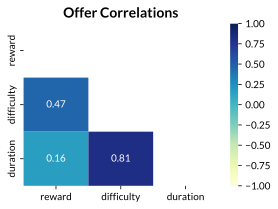

In [17]:
plt.figure(figsize=(4, 3))

num_cols = offer.select_dtypes(['int', 'float']).columns
corr_df = offer[num_cols]
mask = np.triu(np.ones_like(corr_df.corr(), dtype=bool))
heatmap = sns.heatmap(corr_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap = 'YlGnBu')
heatmap.set_title('Offer Correlations', fontsize = 14, weight = 'bold')

plt.tight_layout()
plt.show()

**Reward, Duration, and Difficulty Observations:**
- There is a medium correlation between difficulty and rewards.
- Duration and difficulty are highly correlated.
- There is not much of a correlation between reward and duration.

## Customer EDA

In [18]:
customer = pd.read_csv('data/cleaned_customer.csv')
customer.head(3)

,gender,age,id,became_member_on,income,year,month_number,day_of_month,month,day_number,day
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7,15,July,5,Saturday
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5,9,May,1,Tuesday
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4,26,April,3,Thursday


**Gender**

In [19]:
# Gender percentages - self explanitory
per =  customer['gender'].value_counts()
gender_per = (per/ len(customer['gender']))*100
gender_per.round(2)

M    57.23
F    41.34
O     1.43
Name: gender, dtype: float64

**Age**
Using **jenkspy**, the ages can be naturally split into groups based on their frequency, and not just arbitrarilly put into a group.

In [20]:
import jenkspy
age_breaks = jenkspy.jenks_breaks(customer['age'], n_classes= 8)
labels = ['18-27', '28-37', '38-46',
          '47-54', '55-62', '63-71', 
          '72-81', '82 and over']

age_group = pd.cut(customer['age'], 
                   bins = age_breaks,  
                   labels = labels,
                   include_lowest=True)

customer['age_group'] = age_group

In [21]:
def percentages(df, column):
    group_percentage = ((df.value_counts(column).sort_index() / df.shape[0] * 100).round(2)).reset_index()
    group_percentage.columns = [column, 'perc']
    return group_percentage

In [22]:
cmap = sns.color_palette(palette='mako')

# Customize graphs
def customize_graph(x, y, xlabel, ylabel, title, average):
    fig, ax = plt.subplots(figsize=(10,6), dpi = 96)
    bar1 = ax.bar(x, y, width=0.6, color=cmap, alpha = 0.8)

    # Remove the spines and create grid
    ax.spines[['top','right','bottom']].set_visible(False)
    ax.grid(linewidth = 1, alpha = 0.25)

    # Reformat x-axis label and tick labels
    ax.set_xlabel(f'{xlabel}', fontsize=12, labelpad=10) # No need for an axis label
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)
    ax.set_xticks(x) # Map integers numbers from the series to labels list

    # Reformat y-axis
    ax.set_ylabel(f'{ylabel}', fontsize=12, labelpad=10)
    ax.yaxis.set_label_position("left")
    ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

    # Add label on top of each bar
    ax.bar_label(bar1, labels=[f'{e:,.1f}%' for e in y], padding=3, color='black', fontsize=10) 

    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s=(f'{title}'), transform=fig.transFigure, ha='left', fontsize=14, weight = 'bold', alpha=.8)
    ax.text(x=0.12, y=.89, s= average, transform=fig.transFigure, ha='left', fontsize=14, alpha=.8)
    # Set source text
    ax.text(x=0.1, y=0.12, s="Data Source: Kaggle - Starbucks Customer Data", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

    plt.show()


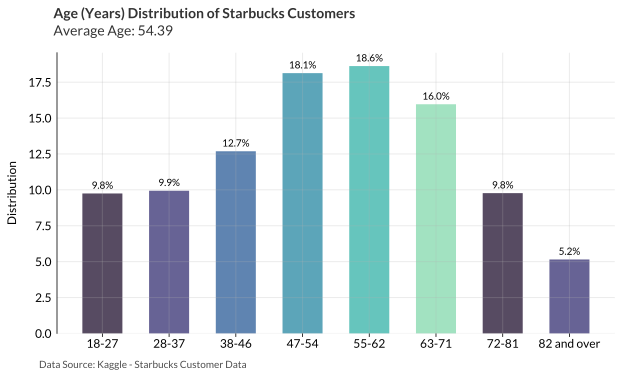

In [23]:
column = 'age_group'
group_percentage = percentages(customer, column)
avg_age = customer['age'].mean()
s=(f'Average Age: {avg_age:,.2f}')
customize_graph(group_percentage[column], group_percentage['perc'], '', 'Distribution', 'Age (Years) Distribution of Starbucks Customers', s)

In [24]:
print("Min: ", customer['age'].min())
print("Max: ", customer['age'].max())

Min:  18
Max:  101


Age Observations: 
- The youngest customer is 18 years old
- The oldest is 101 years old
- The majoritiy of customers are between 42 and 66 with the mean age around 54 years old. 

**Income**

In [25]:
customer['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [26]:
# Similar to age groups
income_breaks = jenkspy.jenks_breaks(customer['income'], n_classes= 6)
labels = ['30-43k', '43-56k', '56-68k',
          '68-83k', '83-100k', 'over 100k']

income_group = pd.cut(customer['income'], 
                   bins = income_breaks,  
                   labels = labels,
                   include_lowest=True)

customer['income_group'] = income_group

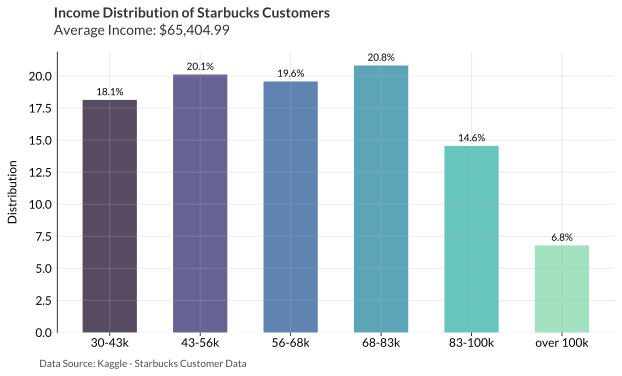

In [27]:
column = 'income_group'
group_percentage = percentages(customer, column)
avg_inc = customer['income'].mean()
s=(f'Average Income: ${avg_inc:,.2f}')
customize_graph(group_percentage[column], group_percentage['perc'], '', 'Distribution', 'Income Distribution of Starbucks Customers', s)

Income Analysis: <br>
The 43-56k and 68-83k income ranges account for the most customers, with the 56-68k income group in a very close second. The top three income ranges (43-83k) account for just over 60% of all customers. 
- Customers make anywhere from $30,000 to $120,000 annually. 
- The majoritiy of customers make between $49,000 and $80,000 with the mean income of ~ $65,404. 

**Member Growth**

In [28]:
# Customize graphs
def countplot(df, x, title, lim1, lim2):
    fig, ax = plt.subplots(figsize=(10,6), dpi=96)
    ax = sns.countplot(data=df, x=x, palette=cmap, alpha = 0.8)
    for container in ax.containers:
        ax.bar_label(container, fontsize=12)

    # Remove the spines and create grid
    ax.spines[['top','right','bottom']].set_visible(False)
    ax.grid(linewidth=1, alpha=0.25)

    # Reformat x-axis label and tick labels
    ax.set_xlabel('', labelpad=10) # No need for an axis label
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)

    # Reformat y-axis
    ax.set_ylabel('', labelpad=10)
    ax.yaxis.set_label_position("left")
    ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)
    ax.set_ylim(lim1, lim2)

    # Add in title and subtitle
    ax.text(x=0.12, y=.93, s=(f'{title}'), transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
    # Set source text
    ax.text(x=0.1, y=0.12, s="Data Source: Kaggle - Starbucks Customer Data", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)
    plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

    plt.show()

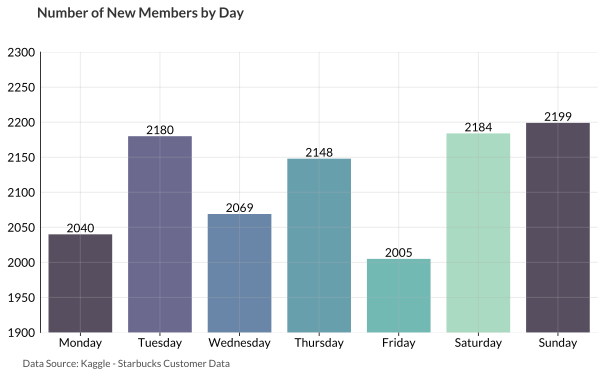

In [29]:
countplot(customer.sort_values('day_number'), 'day', 'Number of New Members by Day', 1900, 2300)

**Member Growth Observations**
- Member growth grew at an almost exponential rate from 2013 to 2017. However, 2018 showed a sharp decline. 
- February is typically the lowest month for member growth. This may be due to February having 2-3 days less than the rest of the months, but not likely. August through January bring in the most customers, suggesting that new member growth is possibly correlated with the US holiday seasons. 
- New memebers are most likely to join over the weekend (Saturday and Sunday). Interestingly, new members are least likely to join on Fridays and Mondays. Tuesday is the best "week" day. 

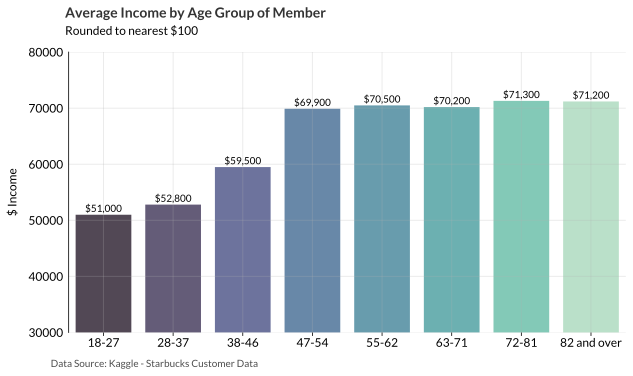

In [30]:
fig, ax = plt.subplots(figsize=(10,6))

age_income = customer.groupby('age_group')['income'].mean().reset_index()
age_income['income'] = age_income['income'].round(-2)

ax = sns.barplot(data = age_income, x = 'age_group', y = 'income', 
                 ci = None, palette= "mako", alpha = 0.8)

# Annotate bar labels
for index, row in age_income.iterrows():
    ax.text(index, row['income'] + 500, f'${int(row["income"]):,}', color='black', ha="center")

# Remove the spines and create grid
ax.spines[['top','right','bottom']].set_visible(False)
ax.grid(linewidth = 1, alpha = 0.25)
# Reformat x-axis label and tick labels
ax.set_xlabel('', fontsize=12, labelpad=10) # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)

# Reformat y-axis
ax.set_ylabel(f'$ Income', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Add in title and subtitle
ax.text(x=0.12, y=.93, s=(f'Average Income by Age Group of Member'), transform=fig.transFigure, ha='left', fontsize=14, weight = 'bold', alpha=.8)
ax.text(x=0.12, y=.89, s=(f'Rounded to nearest $100'), transform=fig.transFigure, ha='left', fontsize=12)

# Set source text
ax.text(x=0.1, y=0.12, s="Data Source: Kaggle - Starbucks Customer Data", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

plt.ylim(30000, 80000)
plt.show()

**Income and Age Observations:**

- The average personal income in the US in 2018 was $ 34,745. The average income in each age group is more than the median US income. 
- It makes sense that the older you are, the more you would make due to experience.
- Customers in the two youngest age groups (18-37 years old) have an average income of just over 50k. The next age group (38-46 years old) has a higher average income of close to 60K. Customers over 47 years of age average 70K or more annually

**Income and Gender**

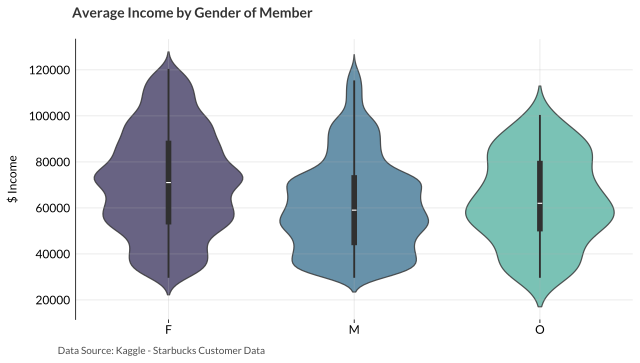

In [31]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.violinplot(data = customer, 
                    x='gender', y='income', 
                    palette = 'mako', alpha = 0.8)

# Remove the spines and create grid
ax.spines[['top','right','bottom']].set_visible(False)
ax.grid(linewidth = 1, alpha = 0.25)

# Reformat x-axis label and tick labels
ax.set_xlabel('', fontsize=12, labelpad=10) # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)


# Reformat y-axis
ax.set_ylabel(f'$ Income', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Add in title and subtitle
ax.text(x=0.12, y=.90, s=(f'Average Income by Gender of Member'), transform=fig.transFigure, ha='left', fontsize=14, weight = 'bold', alpha=.8)
# Set source text
ax.text(x=0.1, y=0.12, s="Data Source: Kaggle - Starbucks Customer Data", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

plt.show()

In [32]:
customer.groupby('gender').agg({'income': 'mean'}).round(0)

,income
gender,
F,71306.0
M,61195.0
O,63288.0


**Income and Gender Observations:** 
- Income of male customers is skewed slightly to the right indicating that males customers are in the lower portion of income. 
- Income of female customers follows a normal distribution. Females have a much higher average income than other genders. 
- The average income of customers identifying as female, male, and other are 71k, 61k and 63k, respectively.

**Age and Gender**

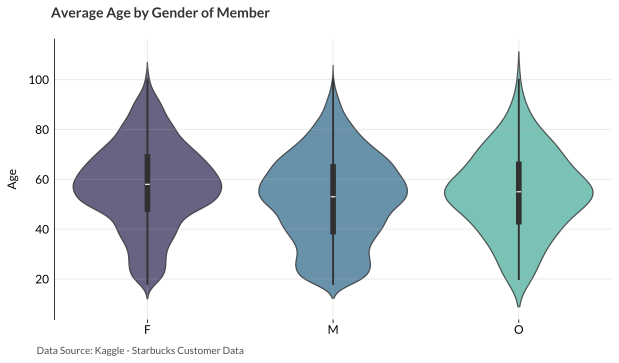

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.violinplot(data = customer, 
                    x='gender', y='age', 
                    palette = 'mako', alpha = 0.8)

# Remove the spines and create grid
ax.spines[['top','right','bottom']].set_visible(False)
ax.grid(linewidth = 1, alpha = 0.25)

# Reformat x-axis label and tick labels
ax.set_xlabel('', fontsize=12, labelpad=10) # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)


# Reformat y-axis
ax.set_ylabel(f'Age', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Add in title and subtitle
ax.text(x=0.12, y=.90, s=(f'Average Age by Gender of Member'), transform=fig.transFigure, ha='left', fontsize=14, weight = 'bold', alpha=.8)
# Set source text
ax.text(x=0.1, y=0.12, s="Data Source: Kaggle - Starbucks Customer Data", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

plt.show()


In [34]:
customer.groupby('gender').agg({'age': 'mean'}).round(1)

,age
gender,
F,57.5
M,52.1
O,54.4


**Age and Gender Observations:** 
- The age of female and male cutomers are somewhat normal in distribution. 
- Interestingly, most of the younger customers are male.
- The average age of customers identifying as female, male, and other are 57.5, 52.1, and 54.4, respectively. 

****
## Transcript Dataframe EDA
#### **Univariate Anaylsis** 
**Event**

In [35]:
transcript = pd.read_csv('data/cleaned_transcript.csv')
transcript.head(3)

,person,event,hours_since_start,key_id,value_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5


In [36]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [37]:
transcript['event'].value_counts()/len(transcript['event'])

transaction        0.453304
offer received     0.248837
offer viewed       0.188315
offer completed    0.109544
Name: event, dtype: float64

**Event Observations:** 
<br>
There are 306,534 total events.
- Transactions make up 45% of the events. Considering only 11% of the events were completed offers, transactions (purchases) continue to occur without any sort of incentive.

- Of the 76,000 offers received, about 58,000 (75.7%) were viewed by customers. This high viewing rate reflects an attractive promotion and high level of customer activity.  

- For the 76,000 offers received and 58,000 offers viewed, around 33,600 offers were completed. This shows that off all received offers, 44% of were later completed. As expected, 62% of the viewed offers turned into a completed offer. The overall completeion of 44% of received offers is high and suggests there is likely a good amount of regulars. 
  
**Event over time**
<br>
Reminder: the transcript dataset used 'time' to represent the number of hours since the promotion began. This was addressed in the cleaning phase by changing the column name to 'hours_since_start'.

In [38]:
# Turning 'hours_since_start' into 'days_since_start'
transcript['days_since_start']= (transcript['hours_since_start']/24).astype(int)

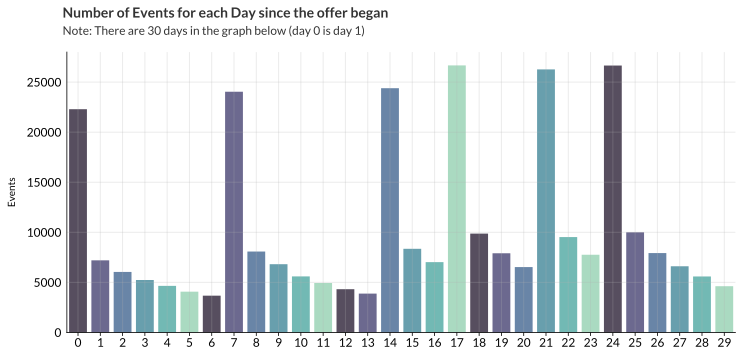

In [39]:
fig, ax = plt.subplots(figsize=(12,6), dpi=96)
ax = sns.countplot(data=transcript, x='days_since_start', palette=cmap, alpha = 0.8)
# for container in ax.containers:
#     ax.bar_label(container, fontsize=12)

# Remove the spines and create grid
ax.spines[['top','right']].set_visible(False)
ax.grid(linewidth=1, alpha=0.25)

# Reformat x-axis label and tick labels
ax.set_xlabel('', labelpad=10) # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)

# Reformat y-axis
ax.set_ylabel('Events', labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Add in title and subtitle
ax.text(x=0.12, y=.93, s=(f'Number of Events for each Day since the offer began'), transform=fig.transFigure, ha='left', fontsize=14, weight='bold', alpha=.8)
ax.text(x=0.12, y=.89, s=('Note: There are 30 days in the graph below (day 0 is day 1)'), transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)

# Set source text
#ax.text(x=0.1, y=0.12, s="Data Source: Kaggle - Starbucks Customer Data", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

plt.show()

**Event Observations:** <br>
There are 6 days during the month with peaks. These peaks should correspond to when 

#### Breaking down timing of events

In [40]:
# Filter the transcript dataframe for each event type
offer_viewed = transcript[transcript['event'] == 'offer viewed']
offer_completed = transcript[transcript['event'] == 'offer completed']
transaction = transcript[transcript['event'] == 'transaction']

# Pivot the dataframes to get the counts of each event type per hour
hourly_views = offer_viewed.pivot_table(index='hours_since_start', aggfunc='size', fill_value=0)
hourly_completed = offer_completed.pivot_table(index='hours_since_start', aggfunc='size', fill_value=0)
hourly_transactions = transaction.pivot_table(index='hours_since_start', aggfunc='size', fill_value=0)

# Create a dataframe with the counts
hourly_merged_df = (pd.DataFrame({'hourly_views': hourly_views, 'hourly_completed': hourly_completed, 'hourly_transactions': hourly_transactions})).reset_index()


In [41]:
hourly_merged_df.head()

,hours_since_start,hourly_views,hourly_completed,hourly_transactions
0,0,2072,206,633
1,6,1433,276,797
2,12,1085,280,850
3,18,884,252,879
4,24,734,265,922


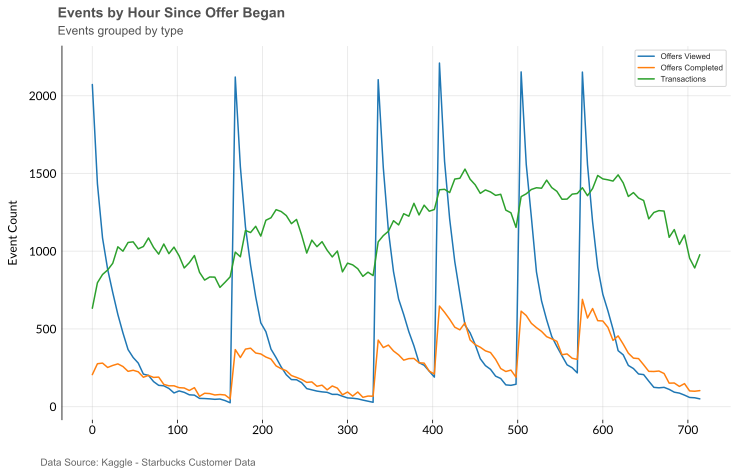

In [42]:
# Plotting each event type
fig, ax = plt.subplots(figsize=(12,8))
sns.set(palette = ("mako_r"))
sns.set(style='whitegrid')#sns.color_palette("mako_r")
column_labels = {
    'hourly_views': 'Offers Viewed',
    'hourly_completed': 'Offers Completed',
    'hourly_transactions': 'Transactions'
}
for column in hourly_merged_df.columns[1:]:
    ax.plot(hourly_merged_df['hours_since_start'], hourly_merged_df[column], label=column_labels[column])
# Remove the spines and create grid
ax.spines[['top','right','bottom']].set_visible(False)
ax.grid(linewidth = 1, alpha = 0.25)

# Reformat x-axis label and tick labels
ax.set_xlabel('', fontsize=12, labelpad=10) # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)

# Reformat y-axis
ax.set_ylabel(f'Event Count', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Add in title and subtitle
ax.text(x=0.12, y=.90, s=(f'Events by Hour Since Offer Began'), transform=fig.transFigure, ha='left', fontsize=14, weight = 'bold', alpha=.8)
ax.text(x=0.12, y=.87, s=(f'Events grouped by type'), transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)

# Set source text
ax.text(x=0.1, y=0.12, s="Data Source: Kaggle - Starbucks Customer Data", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)
# Set a white background

# Add legend
ax.legend(loc="best", fontsize=8)

# Show the plot
plt.show()

In [43]:
# Filter the transcript dataframe for each event type
offer_received = transcript[transcript['event'] == 'offer received']

# Pivot the dataframes to get the counts of each event type per Day
daily_received = offer_viewed.pivot_table(index='days_since_start', aggfunc='size', fill_value=0)
daily_views = offer_viewed.pivot_table(index='days_since_start', aggfunc='size', fill_value=0)
daily_completed = offer_completed.pivot_table(index='days_since_start', aggfunc='size', fill_value=0)
daily_transactions = transaction.pivot_table(index='days_since_start', aggfunc='size', fill_value=0)

# Create a dataframe with the counts
daily_merged_df = (pd.DataFrame({'daily_recieved' : daily_received, 
                                 'daily_views': daily_views, 
                                 'daily_completed': daily_completed, 
                                 'daily_transactions': daily_transactions})).reset_index()

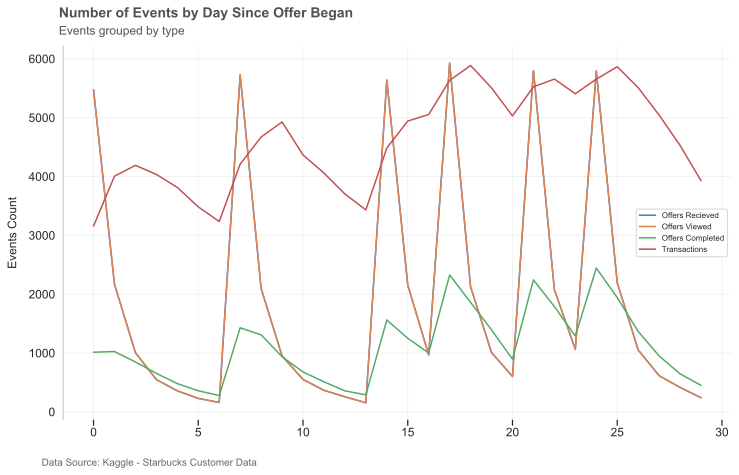

In [44]:
# Plotting each event type
fig, ax = plt.subplots(figsize=(12,8))
# sns.set(palette = ("mako_r"))
# sns.set(style='whitegrid')#sns.color_palette("mako_r")
column_labels = {
    'daily_recieved' : 'Offers Recieved',
    'daily_views' : 'Offers Viewed',
    'daily_completed': 'Offers Completed',
    'daily_transactions': 'Transactions'}

for column in daily_merged_df.columns[1:]:
    ax.plot(daily_merged_df['days_since_start'], daily_merged_df[column], label=column_labels[column])
# Remove the spines and create grid
ax.spines[['top','right','bottom']].set_visible(False)
ax.grid(linewidth = 1, alpha = 0.25)

# Reformat x-axis label and tick labels
ax.set_xlabel('', fontsize=12, labelpad=10) # No need for an axis label
ax.xaxis.set_label_position("bottom")
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=0)

# Reformat y-axis
ax.set_ylabel(f'Events Count', fontsize=12, labelpad=10)
ax.yaxis.set_label_position("left")
ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

# Add in title and subtitle
ax.text(x=0.12, y=.90, s=(f'Number of Events by Day Since Offer Began'), transform=fig.transFigure, ha='left', fontsize=14, weight = 'bold', alpha=.8)
ax.text(x=0.12, y=.87, s=(f'Events grouped by type'), transform=fig.transFigure, ha='left', fontsize=12, alpha=.8)

# Set source text
ax.text(x=0.1, y=0.12, s="Data Source: Kaggle - Starbucks Customer Data", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)
plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)
# Set a white background

# Add legend
ax.legend(loc="best", fontsize=8)

# Show the plot
plt.show()

**Events Observations:**
- Completed offers are very predictable based on the pattern of offers viewed. Both the hourly and daily plots show large peaks in offers viewed followed rather quickly by a small peak in offers completed. This suggests that upon viewing the received offer, customers completed/used the offer mostly in a matter of hours. 

- Transactions are correlated to offers received and completed, but the pattern isn't as obvious. On a daily basis, there is as a slight increase in transactions during the offer received peaks. It makes sense that transactions increase when an offere is completed. However, after the peak in completed offers, transactions continue to increase for a few days before declining. This suggests that customers come in because of the offer, but create a "routine" that causes them to continue to come back without offers. 

In [45]:
# Save changes for part 3
offer.to_csv('data/updated_offer.csv', index= False)
customer.to_csv('data/updated_customer.csv', index = False)
transcript.to_csv('data/updated_transcript.csv', index = False)